In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import Data

In [70]:
df = pd.read_excel('Telco_customer_churn.xlsx')

In [71]:
df.head(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


#Data Wrangling

In [72]:
df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

Last four columns contain the pre-exist interview information. Every customer may not participate in the pre-exit survey therefore the last four columns will not be used for prediction purpose. 

In [73]:
df.drop(columns=['Churn Label','Churn Score','CLTV','Churn Reason'], axis=1, inplace=True)


In [74]:
column_unique_values = {}
for column in df.columns:
  column_unique_values[column]=df[column].unique()



In [75]:
print("\033[1mUnique Values\033[0m")
print('')
for column,value in column_unique_values.items():
  if len(value) < 15:
    print(f'\033[1m{column}\033[0m: {value}')


Unique Values

Count: [1]
Country: ['United States']
State: ['California']
Gender: ['Male' 'Female']
Senior Citizen: ['No' 'Yes']
Partner: ['No' 'Yes']
Dependents: ['No' 'Yes']
Phone Service: ['Yes' 'No']
Multiple Lines: ['No' 'Yes' 'No phone service']
Internet Service: ['DSL' 'Fiber optic' 'No']
Online Security: ['Yes' 'No' 'No internet service']
Online Backup: ['Yes' 'No' 'No internet service']
Device Protection: ['No' 'Yes' 'No internet service']
Tech Support: ['No' 'Yes' 'No internet service']
Streaming TV: ['No' 'Yes' 'No internet service']
Streaming Movies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'Two year' 'One year']
Paperless Billing: ['Yes' 'No']
Payment Method: ['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn Value: [1 0]


Columns Count, Country, and State have only 1. Therefore getting rid of the three columns is the right thing to do as they don't provide any useful information for the purpose of classification. 

In [76]:
df.drop(columns=['Count','Country','State','CustomerID','Lat Long'], axis=1, inplace=True)


In [77]:
df['City'].replace(' ', '_', regex=True, inplace=True) # For the purpose of building the decision tree

In [78]:
df.columns = df.columns.str.replace(' ','_')
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [47]:
df.isnull().sum()

City                 0
Zip_Code             0
Latitude             0
Longitude            0
Gender               0
Senior_Citizen       0
Partner              0
Dependents           0
Tenure_Months        0
Phone_Service        0
Multiple_Lines       0
Internet_Service     0
Online_Security      0
Online_Backup        0
Device_Protection    0
Tech_Support         0
Streaming_TV         0
Streaming_Movies     0
Contract             0
Paperless_Billing    0
Payment_Method       0
Monthly_Charges      0
Total_Charges        0
Churn_Value          0
dtype: int64

In [48]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [82]:
len(df.loc[df['Total_Charges'] == ' ']) # Column Total_charges has 11 mising values

0

In [80]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

In [81]:
df.replace(' ','_',regex=True, inplace=True) # for the purpose of printing the decision tree

In [83]:
X = df.drop(columns='Churn_Value',axis = 1)
y = df['Churn_Value'].copy()

#One-Hot Encoding

In [84]:
X_encoded = pd.get_dummies(X, columns=['City','Gender','Senior_Citizen','Partner','Dependents',
                                       'Phone_Service','Multiple_Lines','Internet_Service',
                                       'Online_Security','Online_Backup','Device_Protection',
                                       'Tech_Support','Streaming_Movies','Contract',
                                       'Paperless_Billing','Payment_Method','Streaming_TV'])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador_City,City_Amboy,City_Anaheim,City_Anderson,City_Angels_Camp,City_Angelus_Oaks,City_Angwin,City_Annapolis,City_Antelope,City_Antioch,City_Anza,City_Apple_Valley,City_Applegate,...,Senior_Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone_Service_No,Phone_Service_Yes,Multiple_Lines_No,Multiple_Lines_No_phone_service,Multiple_Lines_Yes,Internet_Service_DSL,Internet_Service_Fiber_optic,Internet_Service_No,Online_Security_No,Online_Security_No_internet_service,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1


In [85]:
X_train, X_test, y_train, y_test= train_test_split(X_encoded,y,random_state=42, stratify=y)

In [86]:
clf = xgb.XGBClassifier(objective='binary:logistic',seed=42)
clf.fit(X_train,y_train,verbose=True,early_stopping_rounds=10,eval_metric='aucpr',eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.578392
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.580597
[2]	validation_0-aucpr:0.590099
[3]	validation_0-aucpr:0.601636
[4]	validation_0-aucpr:0.608932
[5]	validation_0-aucpr:0.603821
[6]	validation_0-aucpr:0.618314
[7]	validation_0-aucpr:0.610906
[8]	validation_0-aucpr:0.620122
[9]	validation_0-aucpr:0.62495
[10]	validation_0-aucpr:0.629252
[11]	validation_0-aucpr:0.628517
[12]	validation_0-aucpr:0.650051
[13]	validation_0-aucpr:0.649035
[14]	validation_0-aucpr:0.650546
[15]	validation_0-aucpr:0.652876
[16]	validation_0-aucpr:0.654922
[17]	validation_0-aucpr:0.655347
[18]	validation_0-aucpr:0.655818
[19]	validation_0-aucpr:0.655958
[20]	validation_0-aucpr:0.656236
[21]	validation_0-aucpr:0.655564
[22]	validation_0-aucpr:0.656688
[23]	validation_0-aucpr:0.657409
[24]	validation_0-aucpr:0.656236
[25]	validation_0-aucpr:0.655347
[26]	validation_0-aucpr:0.656541
[27]	validation_0-aucpr:0.657225
[28]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

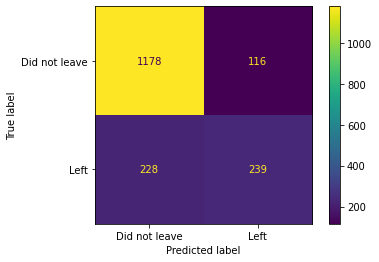

In [90]:
plot_confusion_matrix(clf,X_test, y_test, values_format='d',display_labels=['Did not leave','Left'])